## Training and deploying a SpatialProp model

This tutorial demonstrates how to train a SpatialProp model from scratch and deploy it for scoring on a coronal mouse tissue brain section. 

We will make use of the `aging_coronal.h5ad` dataset from [Sun et al., 2025](https://www.nature.com/articles/s41586-024-08334-8). This dataset includes coronal brain sections from mice at 20 different ages tiling the entire lifespan. Spatial transcriptomics of 300 genes were profiled with MERFISH technology. To download the dataset, run the following cell:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! mkdir -p ./data
! if [ ! -f ./data/aging_coronal.h5ad ]; then \
      echo "Downloading aging_coronal.h5ad..."; \
      wget https://zenodo.org/records/13883177/files/aging_coronal.h5ad -O ./data/aging_coronal.h5ad; \
    else \
      echo "File already exists: ./data/aging_coronal.h5ad — skipping download."; \
  fi

File already exists: ./data/aging_coronal.h5ad — skipping download.


With SpatialProp installed (see Installation section of [README.md](../README.md)), run the following cell to import the API:

In [9]:
import os
import scanpy as sc 
import torch

from spatial_gnn.api.perturbation_api import (
    train_perturbation_model,
    create_perturbation_input_matrix,
    predict_perturbation_effects, 
    predict_perturbation_effects
)
from spatial_gnn.utils.plot_utils import (
    plot_loss_curves,
    plot_celltype_performance,
    plot_gene_in_section,
)

### Define and train the GNN

Training the SpatialProp GNN requires defining the set of training arguments detailed in the [perturbation training API](../src/spatial_gnn/api/perturbation_api.py) docstring. Here we reuse the model configuration reported in the paper. 

Graphs are constructed using 2-hop neighbors centered around cells of all cell types, and we limit to 100 cells per cell type. We augment the training and test sets with 2-hop neighborhood graphs around each surrounding cell. Here we train the base model which does not use cell type labels as a feature.

For the purposes of the demo, we train using a single mouse's data and evaluate on a held-out mouse's data.

In [4]:
adata_path = "./data/aging_coronal.h5ad"
train_ids = ["14"]
test_ids = ["11"]
exp_name = "api_demo"

In [5]:
training_args = {
    "dataset": "aging_coronal",
    "exp_name": "api_demo",
    "file_path": adata_path,
    "train_ids": train_ids, 
    "test_ids": test_ids,
    "k_hop": 2,
    "augment_hop": 2,
    "center_celltypes": "all",
    "node_feature": "expression",
    "inject_feature": "none",
    "learning_rate": 0.0001,
    "loss": "weightedl1",
    "epochs": 30,
    "normalize_total": True,
    "num_cells_per_ct_id": 100,
    "predict_celltype": False,
    "pool": "center",
    "do_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "overwrite": True,
}

The training API call will trigger construction of the graph dataset in the `./data/gnn_datasets/` directory.

Training new perturbation model from scratch...
Model will be saved to: ./output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04
Training on device: cuda
Creating new dataset at: ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_11/test

Processing file 1/1: aging_coronal.h5ad
  Normalizing data


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  Processing 1 samples
  Using sequential processing for 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

Sample 1: 11 (PID: 3154772)


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 1615 center cells from 68661 total cells


/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/src/spatial_gnn/datasets/spatial_dataset.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y = torch.tensor([graph_label]).flatten(),


Created 1615 subgraphs


100%|██████████| 1/1 [03:08<00:00, 188.28s/it]

Created 22013 augmented subgraphs


Total subgraphs created: 23628
Finished processing test dataset
Creating new dataset at: ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_14/train

Processing file 1/1: aging_coronal.h5ad
  Normalizing data


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  Processing 1 samples
  Using sequential processing for 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

Sample 1: 14 (PID: 3154772)


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 1652 center cells from 80194 total cells
Created 1652 subgraphs


100%|██████████| 1/1 [04:15<00:00, 255.34s/it]

Created 23227 augmented subgraphs


Total subgraphs created: 24879
Finished processing train dataset


100%|██████████| 51/51 [00:17<00:00,  2.95it/s]
/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 49/49 [00:17<00:00,  2.82it/s]

Train samples: 24879
Test samples: 23628


Expression model initialized on cuda
Starting Baseline training for 30 epochs...
 Epoch: 001, Train WL1: 9.5205, Test WL1: 9.5170, Test Spearman: 0.1380
 Epoch: 002, Train WL1: 8.6376, Test WL1: 8.6523, Test Spearman: 0.3505
 Epoch: 003, Train WL1: 8.0666, Test WL1: 8.0655, Test Spearman: 0.4964
 Epoch: 004, Train WL1: 7.7798, Test WL1: 7.7636, Test Spearman: 0.5317
 Epoch: 005, Train WL1: 7.5708, Test WL1: 7.5478, Test Spearman: 0.5473
 Epoch: 006, Train WL1: 7.4066, Test WL1: 7.3871, Test Spearman: 0.5583
 Epoch: 007, Train WL1: 7.2907, Test WL1: 7.2604, Test Spearman: 0.5658
 Epoch: 008, Train WL1: 7.1740, Test WL1: 7.1487, Test Spearman: 0.5714
 Epoch: 009, Train WL1: 7.0897, Test WL1: 7.0575, Test Spearman: 0.5777
 Epoch: 010, Train WL1: 7.0089, Test WL1: 6.9776, Test Spearman: 0.5795
 Epoch: 011, Train WL1: 6.9416, Test WL1: 6.9071, Test Spearman: 0.5839
 Epoch: 012, Train WL1: 6.8760, Test WL1: 6.8399, Test Spearman: 0.5875
 Epoch: 013, Train WL1: 6.8187, Test WL1: 6.7820, Test 

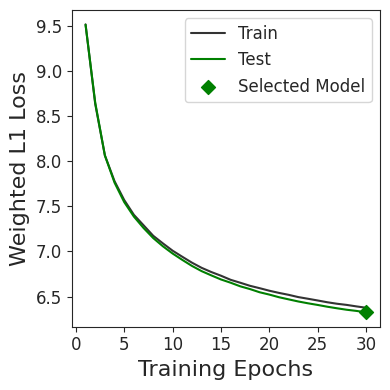

Measuring model predictive performance bulk and by cell type...


100%|██████████| 47/47 [00:04<00:00, 10.96it/s]


Computing micro and macro averages...
Finished cell type analysis.
Training completed. Model saved to: output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04/model.pth


In [6]:
test_loader, gene_names, (model, model_config, trained_model_path) = train_perturbation_model(
    **training_args,
)

### Inspect GNN training performance

We can inspect the GNN training performance using `plot_utils`. We first verify convergence during training by plotting loss curves for the weighted-l1 loss used during training:

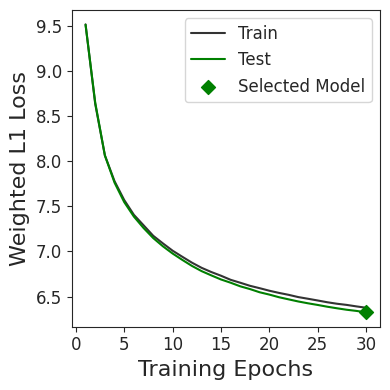

In [10]:
model_dir = os.path.dirname(trained_model_path)
plot_loss_curves(model_dir)

We can also plot performance per cell type. Here we show correlation metrics for the masked center cell expression predicted during training.

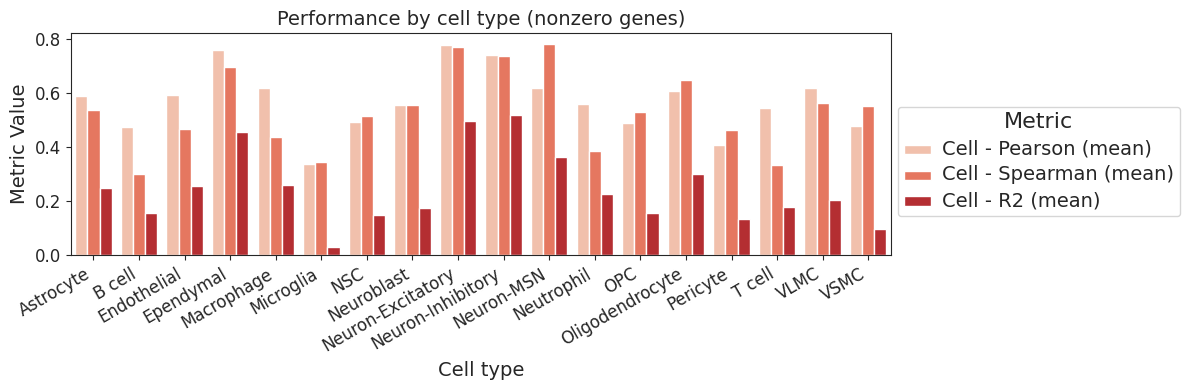

In [12]:
plot_celltype_performance(model_dir)

### Inference on the deployed SpatialProp model

Now that we have trained the SpatialProp model, we can use it to predict spatial propagations in unseen data. Here we again use held-out `mouse_id` 11. First define a set of perturbations in the form of a dictionary mapping `cell type` → `gene name` → `multiplier`. For instance, entry `'T cell': {'Igf2': 0.0},` indicates knockout of IGF2 in all T cells. 

In this example, we amplify pro-inflammatory cytokines IL-6, TNF, and IFN-γ by a factor of 10 in T cells and microglia:

In [13]:
perturbation_dict = {
    'T cell': {'Il6': 10.0, 'Tnf': 10.0, 'Ifng': 10.0},    
    'Microglia': {'Il6': 10.0, 'Tnf': 10.0, 'Ifng': 10.0},          
}
save_path = "./data/perturbed_adata/aging_coronal_perturbed.h5ad"

We call `create_perturbation_input_matrix()` to save down the perturbed input expression into the anndata object. By default, this is saved into `anndata.obsm['perturbed_input']`.

In [16]:
adata = sc.read_h5ad(adata_path)
save_path = create_perturbation_input_matrix(adata, perturbation_dict, save_path=save_path)

Applying perturbations to 1042 cells of type 'T cell'
  - Gene 'Il6': multiplier = 10.0
  - Gene 'Tnf': multiplier = 10.0
  - Gene 'Ifng': multiplier = 10.0
Applying perturbations to 55514 cells of type 'Microglia'
  - Gene 'Il6': multiplier = 10.0
  - Gene 'Tnf': multiplier = 10.0
  - Gene 'Ifng': multiplier = 10.0
Saved AnnData with perturbation input to: ./data/perturbed_adata/aging_coronal_perturbed.h5ad


We can now call the main function which performs the spatial propagations. Internally, this calls the SpatialProp model for each cell in the dataset and executes the SparseRenorm procedure to temper the predictions.

In [ ]:
adata_result = predict_perturbation_effects(
    save_path, trained_model_path, exp_name, use_ids=test_ids
)

Loaded model configuration:
  - input_dim: 300
  - output_dim: 300
  - inject_dim: 0
  - num_layers: 2
  - method: GIN
  - pool: center
Loaded pretrained model from: output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04/model.pth
Creating graphs from input data...
Creating new dataset at: ./data/gnn_datasets/api_demo_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_11/predict

Processing file 1/1: aging_coronal_perturbed.h5ad
  Normalizing data


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  Processing 1 samples
  Using sequential processing for 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

Sample 1: 11 (PID: 3154772)


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 68661 center cells from 68661 total cells
Created 68661 subgraphs


### Visualize SpatialProp results